In [15]:

from tensorflow.keras.layers import Conv2D, TimeDistributed,Dropout,Input, Dense,\
    BatchNormalization, GRU, Layer, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

# Neural Network

In [26]:
def nn(shape_1,shape_2):
    input = Input(shape=[None, shape_1,shape_2,1])

    conv1 = TimeDistributed(Conv2D(filters=32, kernel_size=[32,1], activation='relu',strides =(3,1)))(input)
    batch1 = TimeDistributed(BatchNormalization())(conv1)


    conv2 = TimeDistributed(Conv2D(filters=32, kernel_size=[32,1], activation='relu',strides =(2,1)))(batch1)
    batch2 = TimeDistributed(BatchNormalization())(conv2)

    conv3 = TimeDistributed(Conv2D(filters=32, kernel_size=[32,1], activation='relu',strides =(2,1)))(batch2)
    batch3 = TimeDistributed(BatchNormalization())(conv3)

    conv4 = TimeDistributed(Conv2D(filters=32, kernel_size=[32,1], activation='relu',strides =(2,1)))(batch3)
    batch4 = TimeDistributed(BatchNormalization())(conv4)

    flat = TimeDistributed(Flatten())(batch4)


    gru1 = GRU(256, activation='relu',return_sequences=True, kernel_regularizer=l2(0.01))(flat)
    drop1 = Dropout(rate=0.4)(gru1)
    batch1 = BatchNormalization()(drop1)

    gru2 = GRU(128, activation='relu',return_sequences=True, kernel_regularizer=l2(0.01))(batch1)
    drop2 = Dropout(rate=0.4)(gru2)
    batch2 = BatchNormalization()(drop2)


    dense = TimeDistributed(Dense(2, activation='softmax'),name = 'output')(batch2)


    return [input], [dense]


# Compile

In [27]:
EPOCH_LENGTH = 30
SAMPLE_RATE = 100

input, output = nn(SAMPLE_RATE*EPOCH_LENGTH,1)
model = Model(inputs=input,outputs=output)

optimizer = Adam(learning_rate=2*1e-4)

# Compile Model
model.compile(optimizer=optimizer, loss={
                  'output': 'sparse_categorical_crossentropy', },
              metrics={
                  'output': 'sparse_categorical_accuracy', },
              sample_weight_mode='temporal')

print(model.summary())

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, None, 3000, 1, 1) 0         
_________________________________________________________________
time_distributed_58 (TimeDis (None, None, 990, 1, 32)  1056      
_________________________________________________________________
time_distributed_59 (TimeDis (None, None, 990, 1, 32)  128       
_________________________________________________________________
time_distributed_60 (TimeDis (None, None, 480, 1, 32)  32800     
_________________________________________________________________
time_distributed_61 (TimeDis (None, None, 480, 1, 32)  128       
_________________________________________________________________
time_distributed_62 (TimeDis (None, None, 225, 1, 32)  32800     
_________________________________________________________________
time_distributed_63 (TimeDis (None, None, 225, 1, 32)  128

# Plot model

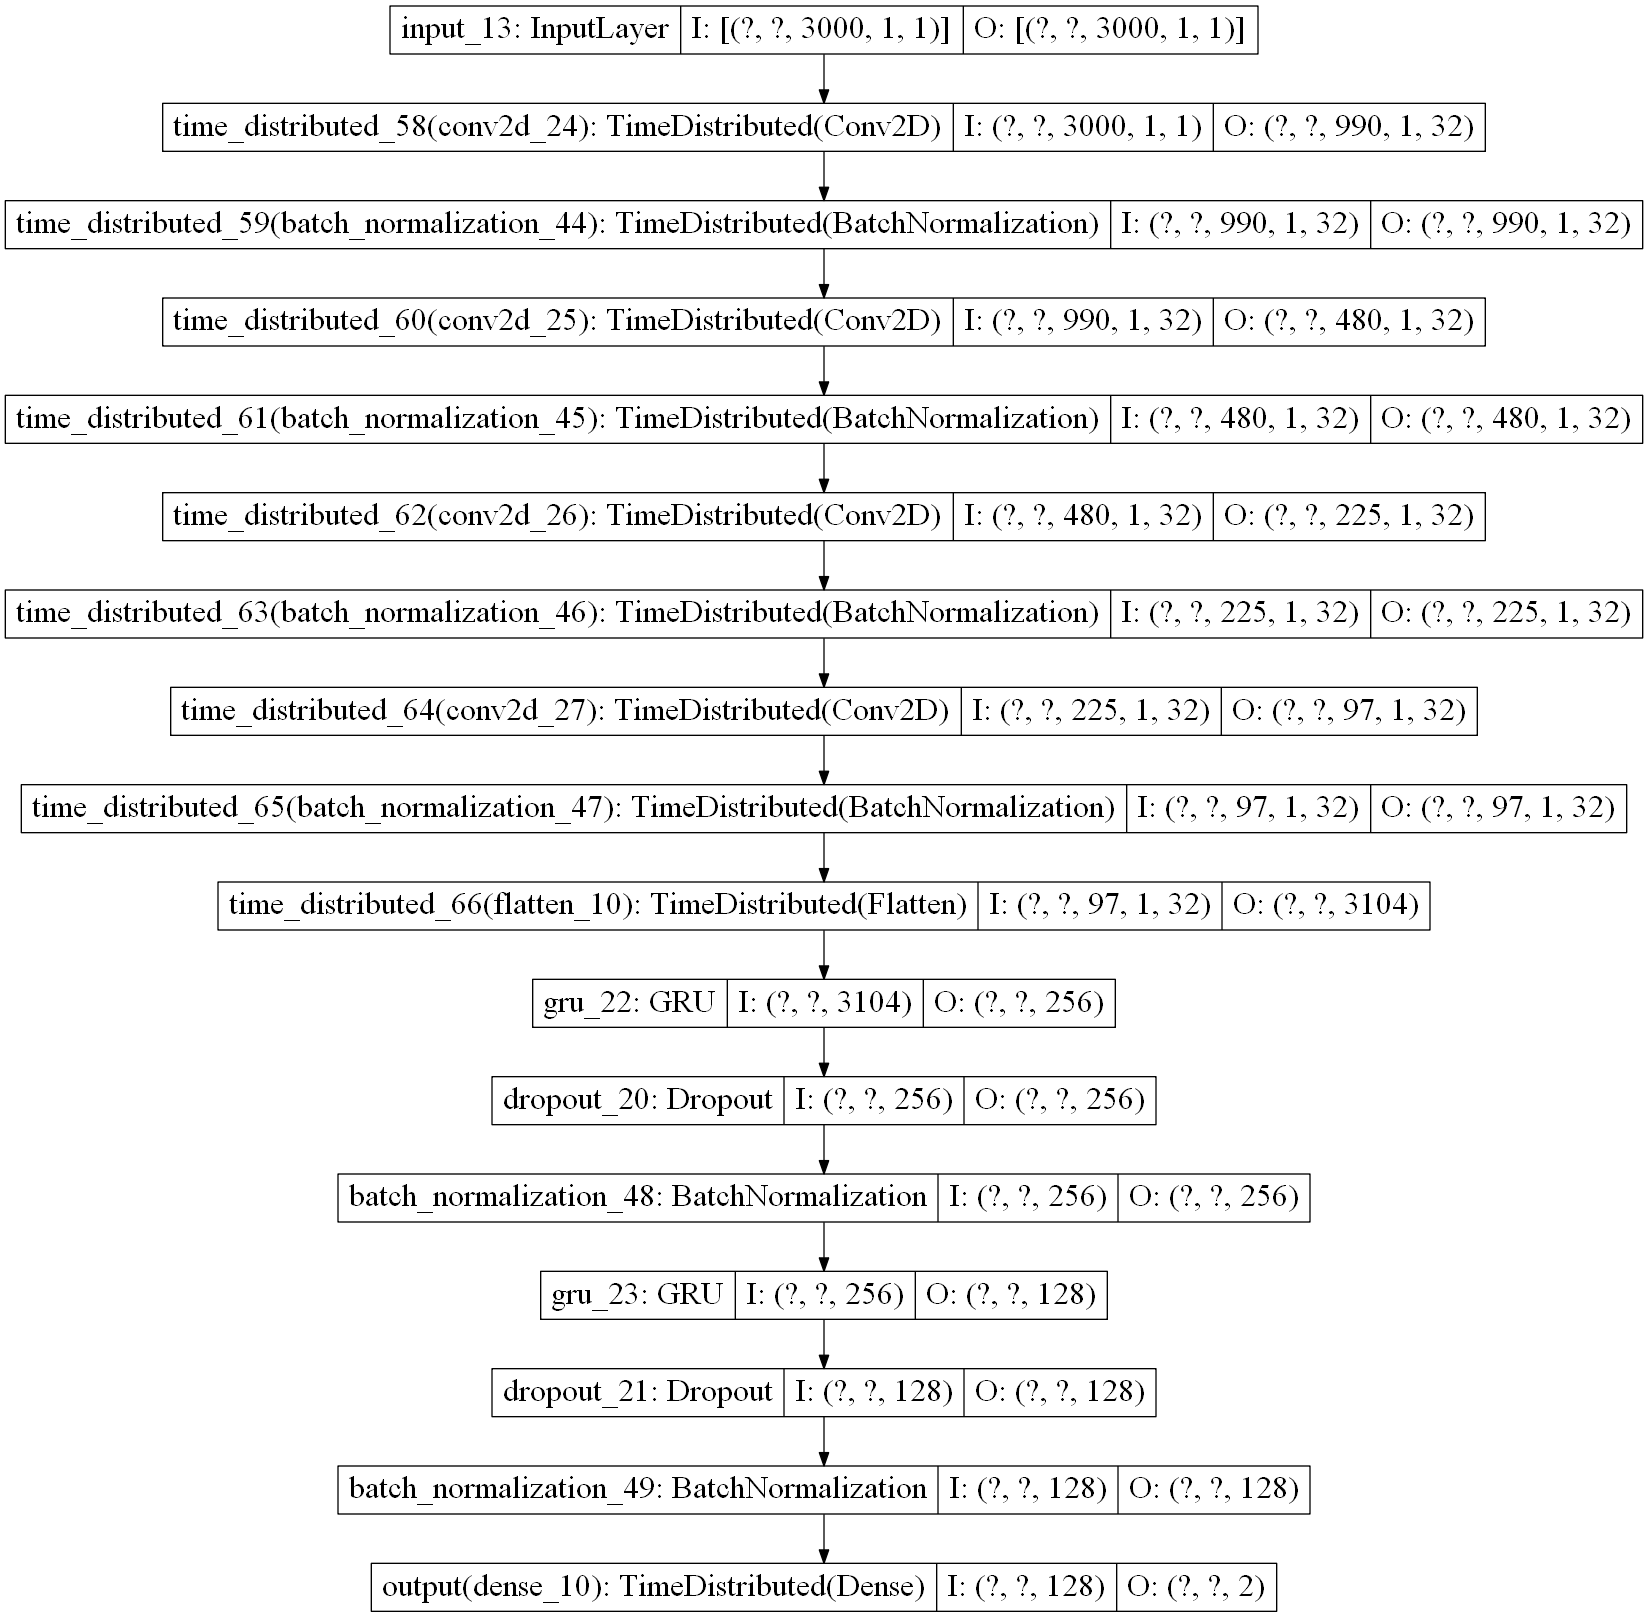

In [28]:
model._layers = [
    layer for layer in model._layers if isinstance(layer, Layer)
]

plot_model(model, 'model.png', show_shapes=True)


In [ ]:

import numpy as np
import re
from os import listdir
from os.path import isfile, join


Extract list of all ids:

In [ ]:
TEST_SIZE = 128
onlyfiles = [f for f in listdir(input_path) if isfile(join(input_path, f))]

id = [re.search('(.+?).npz', x).group(1) for x in onlyfiles]
id.sort()

np.random.seed(1234)
id_test = np.random.choice(id, size=TEST_SIZE,replace=False)
id = list(set(id) - set(id_test))
id_validation = np.random.choice(id, size=TEST_SIZE,replace=False)
id = list(set(id) - set(id_validation))

print(len(id))

training_generator = DataGenerator(id,  input_path = input_path,
                                   target_path=target_path)

validation_generator = DataGenerator(id_validation, input_path = input_path,
                                   target_path=target_path)

# Fit

In [ ]:
model.fit(training_generator,
                    validation_data=validation_generator,
                    epochs=8,
                    use_multiprocessing=True)
